## Cleaning, Feature, Engineering, EDA

Add stemmed and lemmatized full text columns, as well as a few engineered variables. Examine frequent and common words, and pairplot for engineered columns to target. 

In [36]:
#Imports
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn import metrics

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [37]:
#read in df, make target binary based of dadjokes
jokes_all = pd.read_csv('../data/jokes.csv')
jokes_all['dad'] = jokes_all['subreddit'].map(lambda x: 1 if x == 'dadjokes' else 0)

# Porter and Lemma
Have to split words out, lemmatize/stem them, and then recombine. Add it to original dataframe

In [38]:
#Porter to stem full_text
#Porter all the words then recombine and output
p_stemmer = PorterStemmer()
def porter(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = p_stemmer.stem(text_l[i])
    return ' '.join(text_l)

jokes_all['porter'] = jokes_all['full_text'].map(porter)
jokes_all[['full_text','porter']].head()

,full_text,porter
0,Anybody know that show Naked and Afraid? That'...,anybodi know that show nake and afraid? that' ...
1,You don't need a therapist.... A 5 year old wi...,you don't need a therapist.... a 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,whi are fizzi drink so tasty? they are soda-lici
3,I tried drag racing the other day It's brutal ...,i tri drag race the other day it' brutal run i...
4,"In the next season of Ozark, Marty becomes the...","in the next season of ozark, marti becom the m..."


In [39]:
#lemmatize full_text
#lemmatize all the words then recombine and output
lemmatizer = WordNetLemmatizer()
def lemonize(text):
    text_l = text.split()
    for i in range(len(text_l)):
        text_l[i] = lemmatizer.lemmatize(text_l[i])
    return ' '.join(text_l)

jokes_all['lemon'] = jokes_all['full_text'].map(lemonize)
jokes_all[['full_text','lemon']].head()

,full_text,lemon
0,Anybody know that show Naked and Afraid? That'...,Anybody know that show Naked and Afraid? That'...
1,You don't need a therapist.... A 5 year old wi...,You don't need a therapist.... A 5 year old wi...
2,Why are fizzy drinks so tasty? They are soda-l...,Why are fizzy drink so tasty? They are soda-li...
3,I tried drag racing the other day It's brutal ...,I tried drag racing the other day It's brutal ...
4,"In the next season of Ozark, Marty becomes the...","In the next season of Ozark, Marty becomes the..."


# Feature Engineering

Adding additional features off for length, word count, and sentiment scores. 

Additionally, add a column trying to utilize potential for jokes that say the punchline in the hook. (ex "Punchline is great"). Avoid english stop words after. 

In [40]:
#WC and length
jokes_all['ft_length'] = jokes_all['full_text'].map(lambda x: len(x))
jokes_all['ft_wc'] = jokes_all['full_text'].map(lambda x: len(x.split()))

#take sentiment for each one and add as column
sent = SentimentIntensityAnalyzer()
jokes_all['sent_compound'] = [sent.polarity_scores(x)['compound'] for x in jokes_all['full_text']]
jokes_all['sent_neg'] = [sent.polarity_scores(x)['neg'] for x in jokes_all['full_text']]
jokes_all['sent_neu'] = [sent.polarity_scores(x)['neu'] for x in jokes_all['full_text']]
jokes_all['sent_pos'] = [sent.polarity_scores(x)['pos'] for x in jokes_all['full_text']]

jokes_all.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,full_text,dad,porter,lemon,ft_length,ft_wc,sent_compound,sent_neg,sent_neu,sent_pos
0,0,Anybody know that show Naked and Afraid?,That's what I call hide and seek with my uncle...,dadjokes,1627664369,Moose908H,3,1,True,Anybody know that show Naked and Afraid? That'...,1,anybodi know that show nake and afraid? that' ...,Anybody know that show Naked and Afraid? That'...,91,18,-0.1779,0.096,0.904,0.0
1,1,You don't need a therapist....,A 5 year old will tell you everything that's w...,dadjokes,1627664264,VERBERD,2,1,True,You don't need a therapist.... A 5 year old wi...,1,you don't need a therapist.... a 5 year old wi...,You don't need a therapist.... A 5 year old wi...,104,19,-0.4767,0.171,0.829,0.0
2,2,Why are fizzy drinks so tasty?,They are soda-licious,dadjokes,1627664007,techtornado,3,1,True,Why are fizzy drinks so tasty? They are soda-l...,1,whi are fizzi drink so tasty? they are soda-lici,Why are fizzy drink so tasty? They are soda-li...,52,9,0.0000,0.000,1.000,0.0
3,3,I tried drag racing the other day,It's brutal running in those heels!,dadjokes,1627662305,Moose908H,1,1,True,I tried drag racing the other day It's brutal ...,1,i tri drag race the other day it' brutal run i...,I tried drag racing the other day It's brutal ...,69,13,-0.7424,0.386,0.614,0.0
4,4,"In the next season of Ozark, Marty becomes the...",Byrde is the Word,dadjokes,1627661919,DinglebarryHandpump,0,1,True,"In the next season of Ozark, Marty becomes the...",1,"in the next season of ozark, marti becom the m...","In the next season of Ozark, Marty becomes the...",72,14,0.0000,0.000,1.000,0.0


In [41]:
#make list of english stop words
english_stop = list(stopwords.words('english'))

#try to apply is/are relation off of title and self_text separated. 
def after_isare(x):
    count = 0
    word_list = x.title.split()
    #look for is/are in all but last word
    for i in range(len(word_list)-1):
        if 'is' == word_list[i] or 'are' == word_list[i]:
            #check if not stopword
            if word_list[i+1] not in english_stop:
                #add count of that word in the selftext
                count += x.selftext.count(word_list[i+1])
    return count

jokes_all['after_isare'] = jokes_all[['title','selftext']].apply(after_isare,axis=1)
jokes_all[jokes_all['after_isare'] > 0]['title']

16                                  Education is important
27                                          Life is though
401                                        My crow is soft
783      Waht is ta the the Sir Isaac Newton’s favouirt...
844      When your wife is angry with you, bring a towe...
                               ...                        
11390    An orphan is waiting by the school gates when ...
11456              the real joke is always in the comments
11648    [One month after the all the family members ha...
11734    If sex with three people is called a Three-som...
11835    A man is reposting at a bar when he tries stan...
Name: title, Length: 67, dtype: object

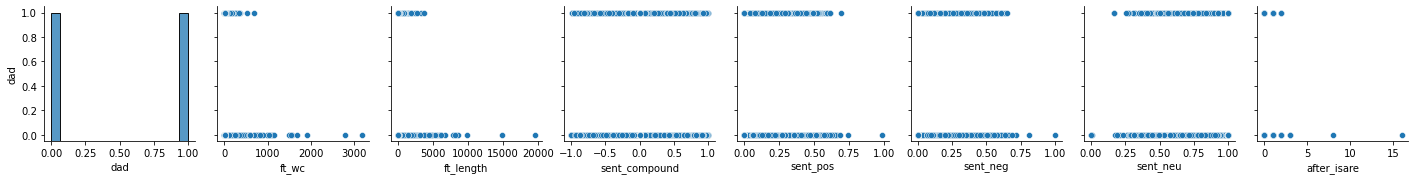

In [42]:
#pairplot for engineered columns to target
sns.pairplot(jokes_all[['dad','ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu','after_isare']],y_vars = ['dad'])


There isn't too much of a giveaway, except for maybe length and wc. Others it is hard to see the density for what is different for the points, since there are 6k posts, it could just be 1 or 2 points in the outliers

# Word visualization

Look to see which words are the most common in each set. Tippy top ones are in common, and further down we ventrue we see more interesting cases. Overlay the top 20 for each with the corresponding count of the other one as well. This helps to show potential imbalances.

English stopwords are avoided here to try to declutter

In [72]:
#split dadjokes and antijokes for examinging word frequency
X = jokes_all['full_text']
y = jokes_all['dad']
X_dj = jokes_all[jokes_all['dad'] == 1]['full_text']
y_dj = jokes_all[jokes_all['dad'] == 1]['dad']
X_aj = jokes_all[jokes_all['dad'] == 0]['full_text']
y_aj = jokes_all[jokes_all['dad'] == 0]['dad']


In [73]:
#CV applied to dadjokes
cvec_dj = CountVectorizer(stop_words='english')
Xcv_dj = cvec_dj.fit_transform(X_dj,y_dj)
Xcv_djdf = pd.DataFrame(Xcv_dj.todense(),columns=cvec_dj.get_feature_names())
Xcv_djdf.head()

,00,000,01k,02,05,07,0mg,0nsznmdxnzu,10,100,...,𝒊𝒏,𝒍𝒊𝒌𝒆𝒏𝒆𝒅,𝒑𝒉𝒂𝒓𝒂𝒐𝒉,𝒕𝒉𝒆,𝒕𝒐,𝒚𝒐𝒖𝒏𝒈𝒆𝒔𝒕,𝙏𝙤𝙤𝙩,𝙖𝙣,𝙘𝙤𝙢𝙢𝙤𝙣,𝙞𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

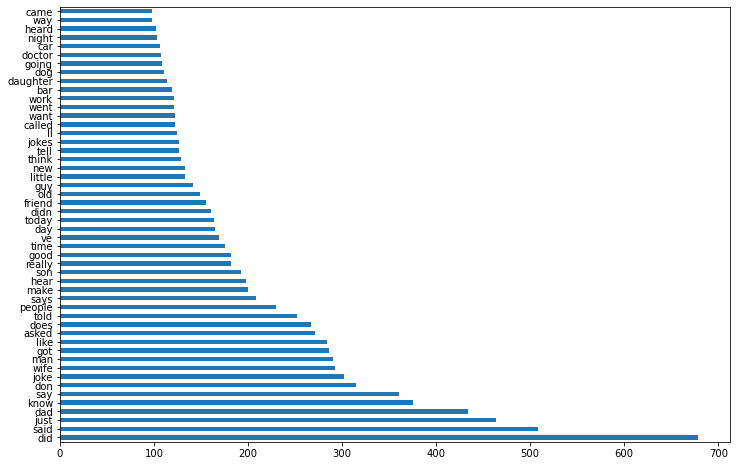

In [74]:
#Plot 50 most common
fig = plt.figure(figsize=(12,8))
Xcv_djdf.sum().sort_values(ascending=False).head(50).plot(kind='barh')

In [75]:
#CV applied to antijokes
cvec_aj = CountVectorizer(stop_words='english')
Xcv_aj = cvec_aj.fit_transform(X_aj,y_aj)
Xcv_ajdf = pd.DataFrame(Xcv_aj.todense(),columns=cvec_aj.get_feature_names())
Xcv_ajdf.head()

,00,000,00000000000000000000000000000001,00100000,003,006,00653875954571505539843239754513915896150297878399377056071435169747221107988,007,01,01100001,...,𝗺𝗶𝘀𝗹𝗲𝗮𝗱𝗶𝗻𝗴,𝗺𝗼𝗿𝗻𝗶𝗻𝗴,𝘀𝗮𝘆,𝘀𝗼𝘂𝗿𝗰𝗲𝘀,𝘀𝘁𝗮𝘁𝗲𝗱,𝘁𝗴𝗲𝘂𝗿,𝘁𝗵𝗲,𝘁𝗵𝗶𝘀,𝘁𝗼,𝘄𝗼𝗿𝗸𝗲𝗿
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

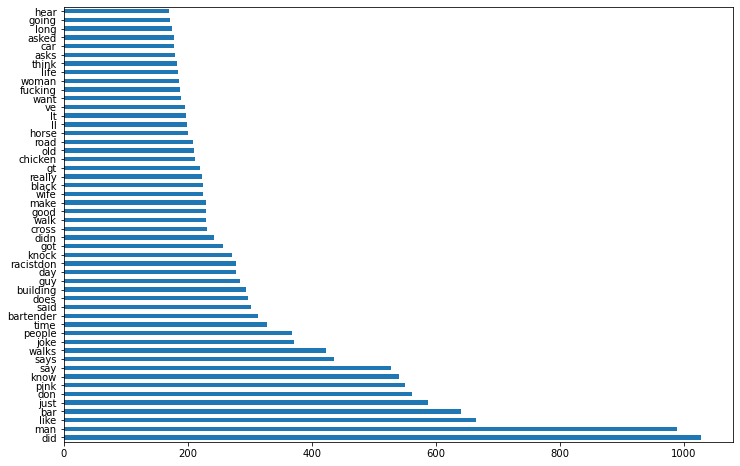

In [76]:
#plot 50 most frequent. 
fig = plt.figure(figsize=(12,8))
Xcv_ajdf.sum().sort_values(ascending=False).head(50).plot(kind='barh')

In [77]:
#Make vector for all, use this to pull the 20 most frequent from each for plotting

X_all = jokes_all['full_text']
cvec_all = CountVectorizer(stop_words='english')
Xcv_all = cvec_all.fit_transform(X_all,jokes_all['dad'])
Xcv_alldf = pd.DataFrame(Xcv_all.todense(),columns=cvec_all.get_feature_names())
Xcv_alldf['dadjoke_flag'] = jokes_all['dad']


In [84]:
#20 most common antijoke words, and corresponding count in dadjoke
list20 = list(zip(list(Xcv_ajdf.sum().sort_values(ascending=False).head(20).keys()),list(Xcv_ajdf.sum().sort_values(ascending=False).head(20))))
word20 = [i for i,j in list20]
anticount20 = [j for i,j in list20]
dadcount20 = [Xcv_djdf[i].sum() for i in word20]
anticount20


[1028,
 988,
 665,
 640,
 588,
 562,
 550,
 541,
 527,
 436,
 423,
 371,
 368,
 328,
 313,
 302,
 297,
 294,
 285,
 278]

In [79]:
#Wrangling the data to make it easy to plot

Xcv_20 = Xcv_alldf[word20+['dadjoke_flag']].groupby('dadjoke_flag').sum()
XcvT20 = Xcv_20.T
XcvT20['sum'] = XcvT20[0] + XcvT20[1]
XcvT20 = XcvT20.sort_values('sum',ascending=False)
XcvT20.index

Index(['did', 'man', 'just', 'like', 'know', 'say', 'don', 'said', 'bar',
       'joke', 'says', 'people', 'does', 'pink', 'time', 'walks', 'day', 'guy',
       'bartender', 'building'],
      dtype='object')

Plotting stacked of 20 most common antijoke words and count of those words in dadjokes sorted by the sum of the two to make it look a bit nicer. Pink is a strong outlier, as well as building and bartender

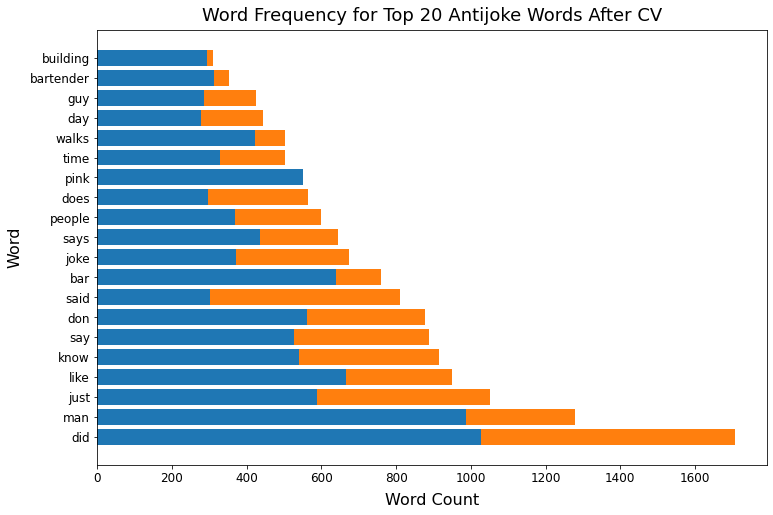

In [80]:
fig = plt.figure(figsize=(12,8))
plt.title('Word Frequency for Top 20 Antijoke Words After CV', fontsize = 18, pad = 9)

#plot antijokes, then dadjokes stacked

plt.barh(list(XcvT20.index),[x for x in XcvT20[0]],label='Dadjokes')
plt.barh(list(XcvT20.index),[x for x in XcvT20[1]],left=[x for x in XcvT20[0]],label='Anitjokes')
plt.xlabel('Word Count',fontsize = 16, labelpad = 8)
plt.xticks(fontsize=12)
plt.ylabel('Word', fontsize = 16, labelpad = 8)
plt.yticks(fontsize=12);

In [86]:
#Only 14 antijoke posts have the word pink
jokes_all[jokes_all['full_text'].str.contains('pink')]['subreddit'].value_counts()

AntiJokes    14
dadjokes      3
Name: subreddit, dtype: int64

In [85]:
#Here is it is, two instances of over 100 pinks in 1 post
Xcv_alldf[Xcv_alldf['pink'] > 100][['pink']]

,pink
6808,399
9956,134


Repeat the process with dadjoke and antijoke rolls reversed. 

In [81]:
#20 most common dadjoke words, and corresponding count in antijoke
list20 = list(zip(list(Xcv_djdf.sum().sort_values(ascending=False).head(20).keys()),list(Xcv_djdf.sum().sort_values(ascending=False).head(20))))
word20 = [i for i,j in list20]
dadcount20 = [j for i,j in list20]
anticount20 = [Xcv_djdf[i].sum() for i in word20]
anticount20


[678,
 508,
 464,
 434,
 375,
 361,
 315,
 302,
 292,
 290,
 286,
 284,
 271,
 267,
 252,
 230,
 208,
 200,
 198,
 192]

In [82]:
#Wrangling the data to make it easy to plot

Xcv_20 = Xcv_alldf[word20+['dadjoke_flag']].groupby('dadjoke_flag').sum()
XcvT20 = Xcv_20.T
XcvT20['sum'] = XcvT20[0] + XcvT20[1]
XcvT20 = XcvT20.sort_values('sum',ascending=False)
XcvT20.index

Index(['did', 'man', 'just', 'like', 'know', 'say', 'don', 'said', 'joke',
       'says', 'people', 'dad', 'does', 'got', 'wife', 'asked', 'make', 'told',
       'hear', 'son'],
      dtype='object')

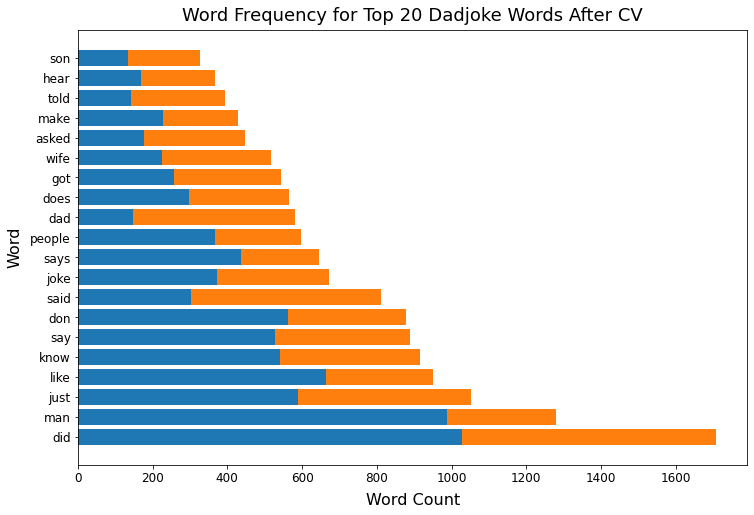

In [83]:
fig = plt.figure(figsize=(12,8))
plt.title('Word Frequency for Top 20 Dadjoke Words After CV', fontsize = 18, pad = 9)

#plot antijokes, then dadjokes stacked

plt.barh(list(XcvT20.index),[x for x in XcvT20[0]],label='Dadjokes')
plt.barh(list(XcvT20.index),[x for x in XcvT20[1]],left=[x for x in XcvT20[0]],label='Anitjokes')
plt.xlabel('Word Count',fontsize = 16, labelpad = 8)
plt.xticks(fontsize=12)
plt.ylabel('Word', fontsize = 16, labelpad = 8)
plt.yticks(fontsize=12);


In [69]:
jokes_all.head()

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,full_text,dad,porter,lemon,ft_length,ft_wc,sent_compound,sent_neg,sent_neu,sent_pos,after_isare
0,0,Anybody know that show Naked and Afraid?,That's what I call hide and seek with my uncle...,dadjokes,1627664369,Moose908H,3,1,True,Anybody know that show Naked and Afraid? That'...,1,anybodi know that show nake and afraid? that' ...,Anybody know that show Naked and Afraid? That'...,91,18,-0.1779,0.096,0.904,0.0,0
1,1,You don't need a therapist....,A 5 year old will tell you everything that's w...,dadjokes,1627664264,VERBERD,2,1,True,You don't need a therapist.... A 5 year old wi...,1,you don't need a therapist.... a 5 year old wi...,You don't need a therapist.... A 5 year old wi...,104,19,-0.4767,0.171,0.829,0.0,0
2,2,Why are fizzy drinks so tasty?,They are soda-licious,dadjokes,1627664007,techtornado,3,1,True,Why are fizzy drinks so tasty? They are soda-l...,1,whi are fizzi drink so tasty? they are soda-lici,Why are fizzy drink so tasty? They are soda-li...,52,9,0.0000,0.000,1.000,0.0,0
3,3,I tried drag racing the other day,It's brutal running in those heels!,dadjokes,1627662305,Moose908H,1,1,True,I tried drag racing the other day It's brutal ...,1,i tri drag race the other day it' brutal run i...,I tried drag racing the other day It's brutal ...,69,13,-0.7424,0.386,0.614,0.0,0
4,4,"In the next season of Ozark, Marty becomes the...",Byrde is the Word,dadjokes,1627661919,DinglebarryHandpump,0,1,True,"In the next season of Ozark, Marty becomes the...",1,"in the next season of ozark, marti becom the m...","In the next season of Ozark, Marty becomes the...",72,14,0.0000,0.000,1.000,0.0,0


In [70]:
#save processed data
jokes_all.to_csv('../data/jokes_processed.csv')